In [31]:
import pandas as pd
import numpy as np
from epidatpy import EpiDataContext, EpiRange
from delphi_epidata import Epidata
import time
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# config
start_week = 201030
end_week = 202540
weeks_range = Epidata.range(start_week, end_week)

# Lists of regions to query
# 1. National
regions_national = ['nat']
# 2. HHS Regions (1-10)
regions_hhs = [f'hhs{i}' for i in range(1, 11)]
# 3. States (Census Regions) - Standard list of US states + DC
regions_states = [
    'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 
    'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 
    'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 
    'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 
    'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy', 'dc'
]

# Combine all wILI regions into one list
all_wili_regions = regions_national + regions_hhs + regions_states

# pull in batches 
chunk_size = 10
wili_frames = []

for i in range(0, len(all_wili_regions), chunk_size):
    batch = all_wili_regions[i:i + chunk_size]
    print(f"   Fetching batch: {batch}")
    
    res = Epidata.fluview(
        regions=batch, 
        epiweeks=weeks_range
    )
    
    if res['result'] == 1:
        df_chunk = pd.DataFrame(res['epidata'])
        # Keep relevant columns + 'region' so we know where data is from
        df_chunk = df_chunk[['epiweek', 'region', 'release_date', 'issue', 'wili', 'num_ili', 'num_patients']]
        wili_frames.append(df_chunk)
    else:
        print(f"   Warning: No data for batch {batch} or API error.")
    
    time.sleep(0.5)

df_wili = pd.concat(wili_frames, ignore_index=True)
df_wili = df_wili.rename(columns={'issue': 'issue_wili', 'release_date': 'date_wili'})

print(f"   Total wILI rows fetched: {len(df_wili)}")


# GET HOSPITALIZATION (FluSurv) 
# If a state isn't in the network, the API will just return empty for it.

print("\n2. Pulling Hospitalizations (FluSurv)...")
# For FluSurv, 'locations' is the parameter, not 'regions'.
hosp_locations = ['network_all'] + regions_states 

hosp_frames = []
# Batching again
for i in range(0, len(hosp_locations), chunk_size):
    batch = hosp_locations[i:i + chunk_size]
    print(f"   Fetching batch: {batch}")
    
    res = Epidata.flusurv(
        locations=batch, 
        epiweeks=weeks_range
    )
    
    if res['result'] == 1:
        df_chunk = pd.DataFrame(res['epidata'])
        # Rename 'location' to 'region' to match wILI for easier merging 
        df_chunk = df_chunk.rename(columns={'location': 'region'})
        df_chunk = df_chunk[['epiweek', 'region', 'release_date', 'issue', 'rate_overall']]
        hosp_frames.append(df_chunk)
    
    time.sleep(0.5)

if hosp_frames:
    df_hosp = pd.concat(hosp_frames, ignore_index=True)
    df_hosp = df_hosp.rename(columns={'issue': 'issue_hosp', 'release_date': 'date_hosp', 'rate_overall': 'hosp_rate'})
    
    # Clean up region names
    # normalize everything to lowercase.
    df_hosp['region'] = df_hosp['region'].str.lower()
    
    df_hosp['region'] = df_hosp['region'].replace('network_all', 'nat')
    
    print(f"   Total Hospitalization rows fetched: {len(df_hosp)}")
else:
    print("   No hospitalization data found.")
    df_hosp = pd.DataFrame()


# Merge wILI and hospitalization
print("\n3. Merging datasets...")
# Merge on BOTH 'epiweek' AND 'region'
if not df_wili.empty and not df_hosp.empty:
    df_master = pd.merge(df_wili, df_hosp, on=['epiweek', 'region'], how='outer')
    
    # Sort
    df_master = df_master.sort_values(['region', 'epiweek']).reset_index(drop=True)
    
    # Save
    filename = 'flu_master_all_regions_2010_2025.csv'
    df_master.to_csv(filename, index=False)
    print(f"Success! Saved {len(df_master)} rows to {filename}")
    
    # Check unique regions
    print("\nRegions included in dataset:")
    print(df_master['region'].unique())

Fetching data from 201030 to 202540...
1. Pulling wILI for 62 regions...
   Fetching batch: ['nat', 'hhs1', 'hhs2', 'hhs3', 'hhs4', 'hhs5', 'hhs6', 'hhs7', 'hhs8', 'hhs9']
   Fetching batch: ['hhs10', 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl']
   Fetching batch: ['ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me']
   Fetching batch: ['md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh']
   Fetching batch: ['nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri']
   Fetching batch: ['sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi']
   Fetching batch: ['wy', 'dc']
   Total wILI rows fetched: 47747

2. Pulling Hospitalizations (FluSurv)...
   Fetching batch: ['network_all', 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl']
   Fetching batch: ['ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me']
   Fetching batch: ['md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh']
   Fetching batch: ['nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 

In [32]:
# Load master file
df = pd.read_csv('flu_master_all_regions_2010_2025.csv')

# Group by region and count how many non-empty hospitalization rows exist
data_counts = df.groupby('region')['hosp_rate'].count().reset_index()

# Filter for regions that have significant data (e.g., more than 100 weeks of reporting)
usable_regions = data_counts[data_counts['hosp_rate'] > 100].sort_values('hosp_rate', ascending=False)

print("Regions with usable Hospitalization data:")
print(usable_regions)

Regions with usable Hospitalization data:
   region  hosp_rate
4      ca        449
5      co        449
6      ct        449
10     ga        449
30     md        449
32     mi        449
33     mn        449
37    nat        449
43     nm        449
46     oh        449
48     or        449
53     tn        449
55     ut        449


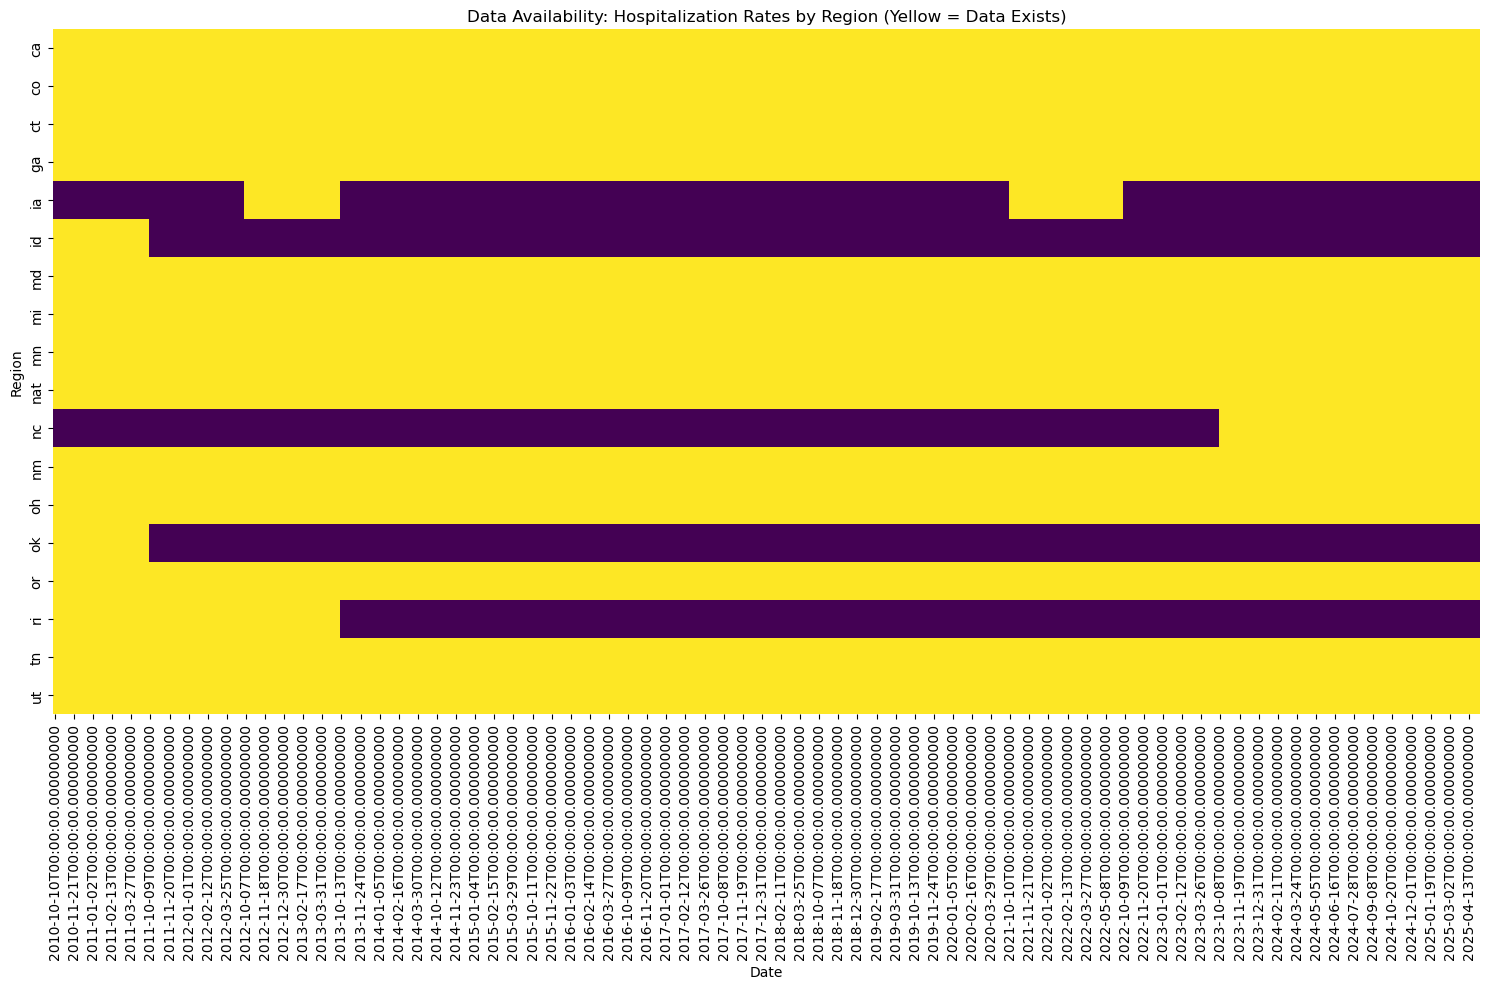

In [33]:
# 1. load data
df = pd.read_csv('flu_master_all_regions_2010_2025.csv')

# Ensure epiweek is an integer to prevent type mismatch duplicates
df['epiweek'] = df['epiweek'].astype(int)

# 2. Create the date column
df['date'] = pd.to_datetime(df['epiweek'].astype(str) + '0', format='%Y%W%w')

pivot_hosp = df.pivot_table(
    index='region', 
    columns='date', 
    values='hosp_rate', 
    aggfunc='first'  
)

# 3. Create Presence Matrix (1 = Data Exists, 0 = NaN)
presence_matrix = pivot_hosp.notnull().astype(int)

# 4. Plot Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(presence_matrix, cmap='viridis', cbar=False, yticklabels=True)
plt.title('Data Availability: Hospitalization Rates by Region (Yellow = Data Exists)')
plt.xlabel('Date')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

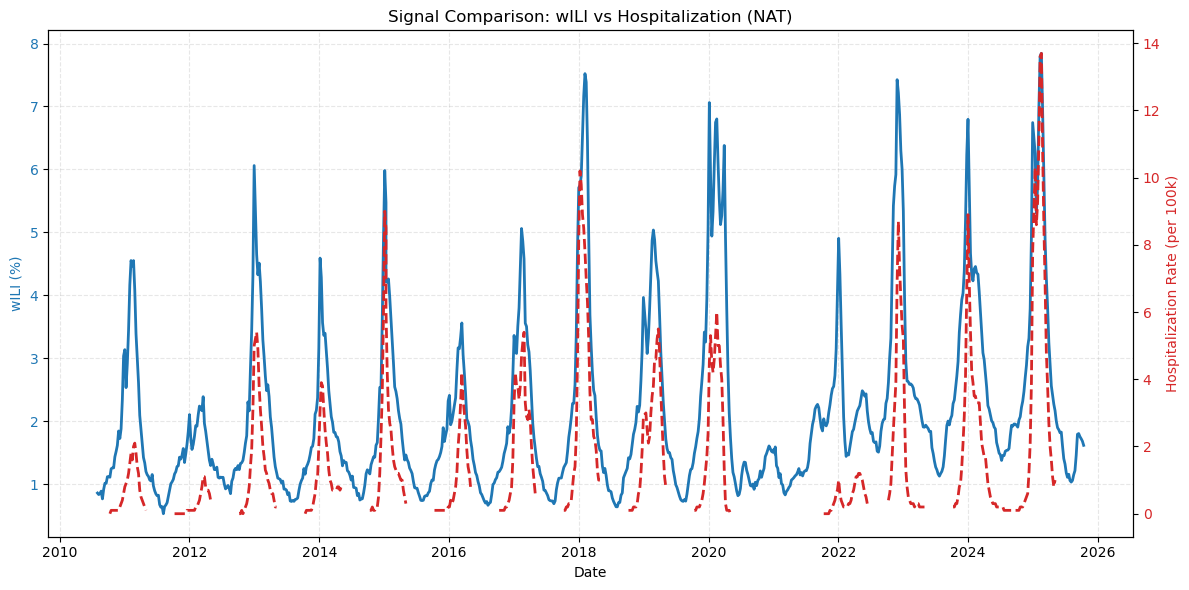

In [36]:
# Choose a region with good data (e.g., 'nat', 'ny', 'ga')
region_to_plot = 'nat' 
subset = df[df['region'] == region_to_plot].sort_values('date')

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot wILI (Blue)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('wILI (%)', color=color)
ax1.plot(subset['date'], subset['wili'], color=color, linewidth=2, label='wILI')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.3)

# Plot Hospitalizations (Red) on Secondary Axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Hospitalization Rate (per 100k)', color=color)
ax2.plot(subset['date'], subset['hosp_rate'], color=color, linewidth=2, linestyle='--', label='Hospitalizations')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Signal Comparison: wILI vs Hospitalization ({region_to_plot.upper()})')
fig.tight_layout()
plt.show()

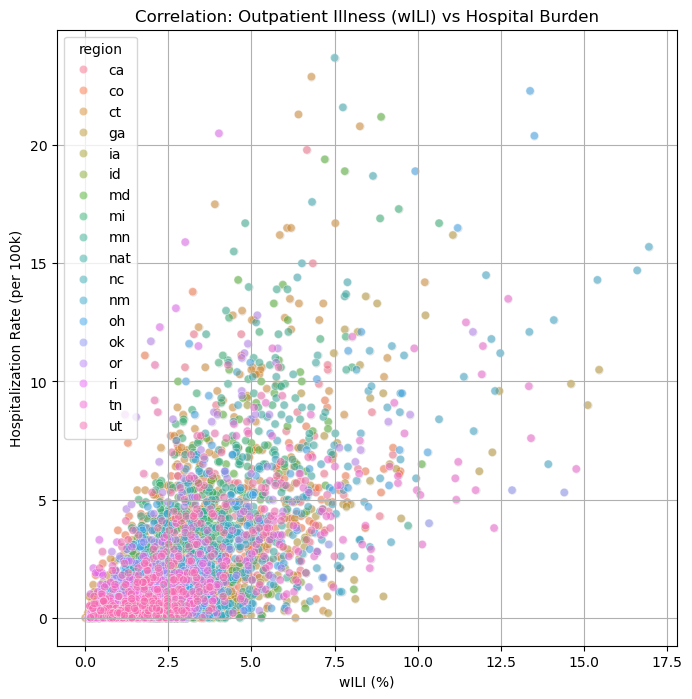

In [37]:
plt.figure(figsize=(8, 8))

# Filter for rows where BOTH measurements exist
valid_data = df.dropna(subset=['wili', 'hosp_rate'])

# Scatter plot
sns.scatterplot(data=valid_data, x='wili', y='hosp_rate', alpha=0.1, color='black')

sns.scatterplot(data=valid_data, x='wili', y='hosp_rate', hue='region', alpha=0.5)

plt.title('Correlation: Outpatient Illness (wILI) vs Hospital Burden')
plt.xlabel('wILI (%)')
plt.ylabel('Hospitalization Rate (per 100k)')
plt.grid(True)
plt.show()

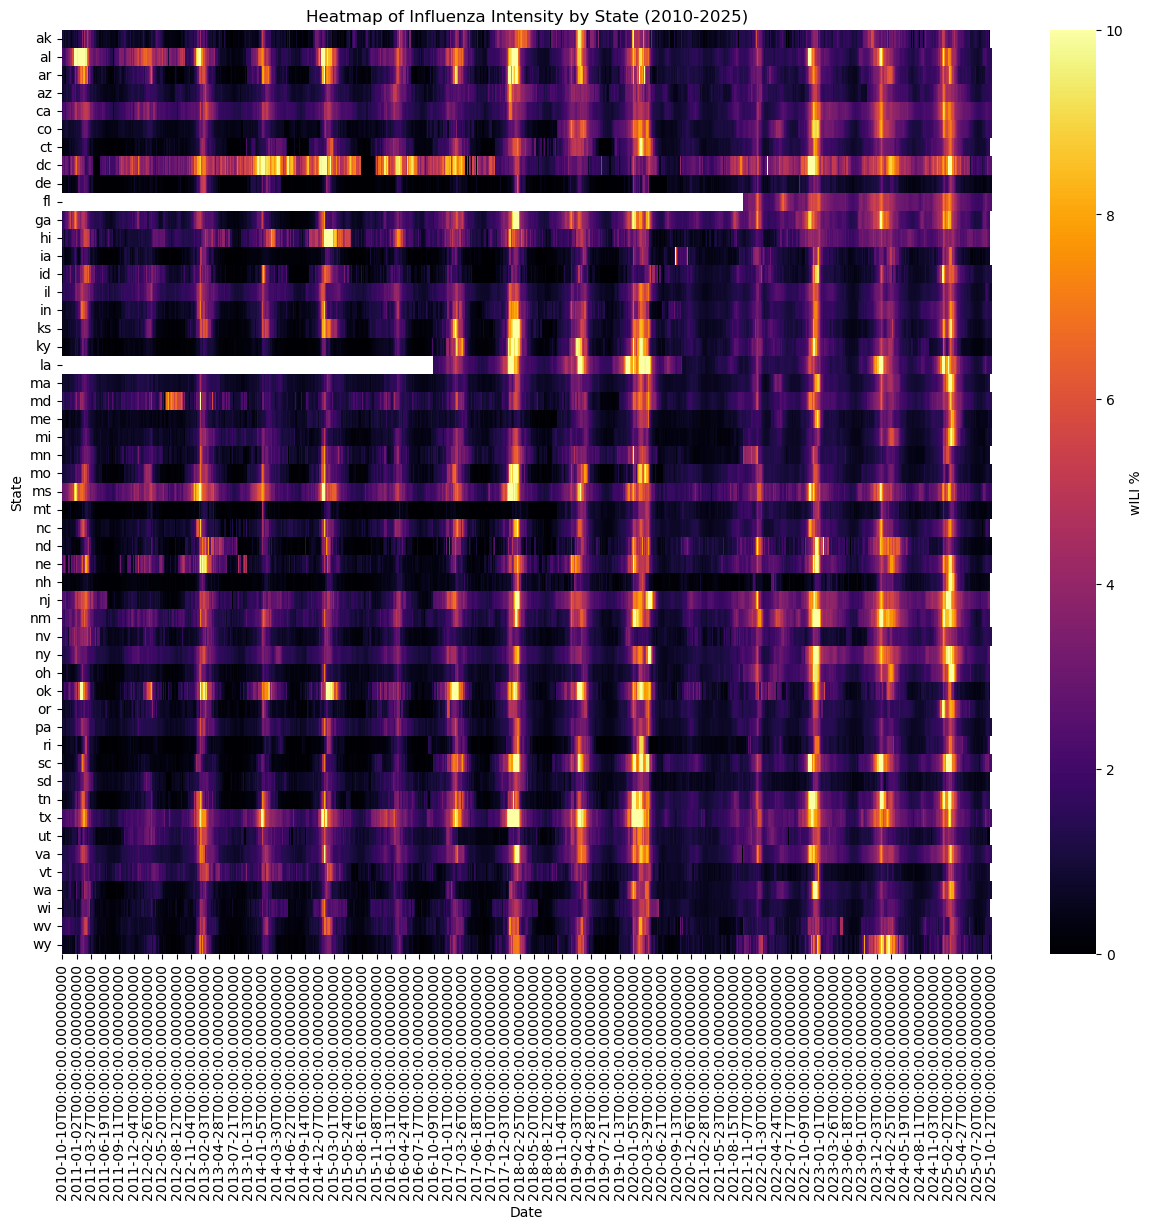

In [38]:
# Load Data
df = pd.read_csv('flu_master_all_regions_2010_2025.csv')
df['date'] = pd.to_datetime(df['epiweek'].astype(str) + '0', format='%Y%W%w')

states_only = df[df['region'].str.len() == 2].copy()

pivot_wili = states_only.pivot_table(index='region', columns='date', values='wili')

# Plot
plt.figure(figsize=(15, 12))
sns.heatmap(pivot_wili, cmap='inferno', vmin=0, vmax=10, cbar_kws={'label': 'wILI %'})
plt.title('Heatmap of Influenza Intensity by State (2010-2025)')
plt.xlabel('Date')
plt.ylabel('State')
plt.show()

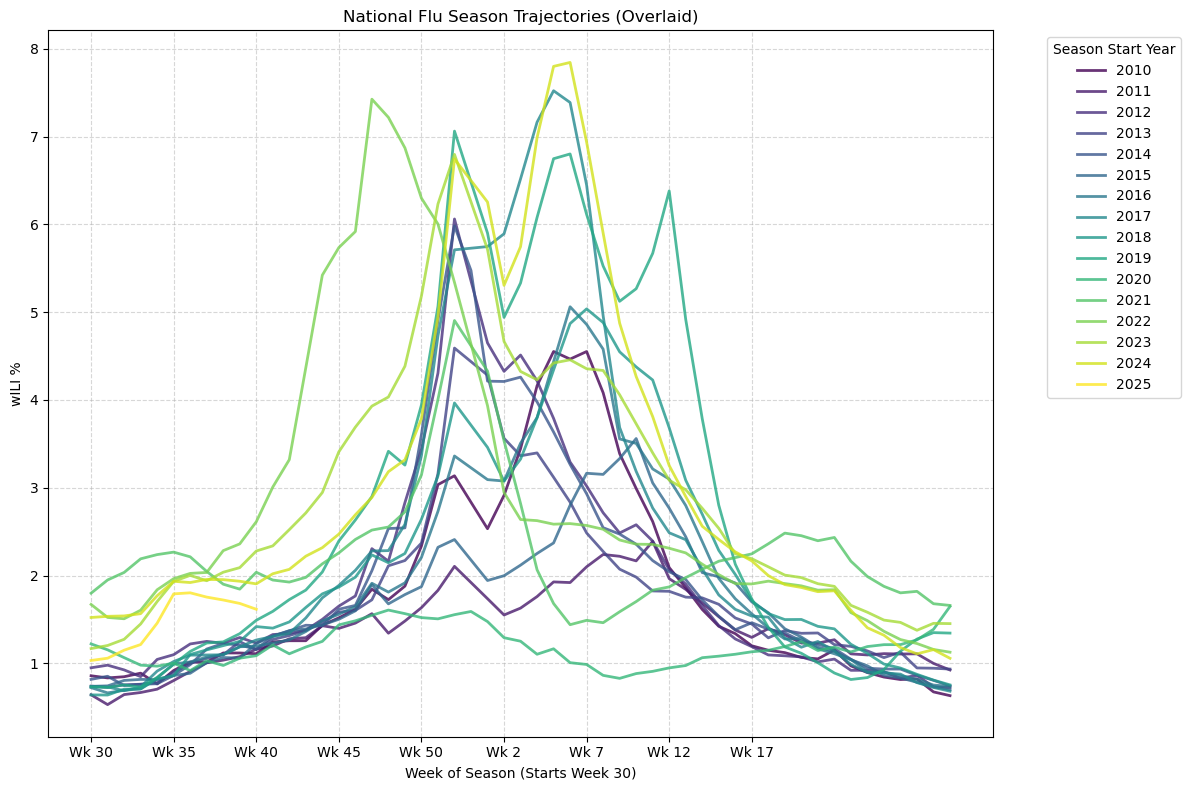

In [39]:
# Create a 'season' column
# Logic: If week >= 30, it belongs to the season of that year (e.g., 2018 wk 40 -> Season 2018)
# If week < 30, it belongs to the previous year (e.g., 2019 wk 05 -> Season 2018)
# Note: epiweek is YYYYWW
df['year'] = df['epiweek'] // 100
df['week'] = df['epiweek'] % 100
df['season_start_year'] = df.apply(lambda x: x['year'] if x['week'] >= 30 else x['year'] - 1, axis=1)

# Filter for National data only to keep it clean
nat_data = df[df['region'] == 'nat'].copy()

# Create a 'plot_week' variable to align seasons
# We want Week 30 to be the start (x=0) and Week 20 (next year) to be the end.
def get_plot_week(w):
    if w >= 30: return w - 30
    else: return w + (53 - 30) # Approx shift for new year weeks

nat_data['plot_week'] = nat_data['week'].apply(get_plot_week)

# Plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=nat_data, 
    x='plot_week', 
    y='wili', 
    hue='season_start_year', 
    palette='viridis', 
    legend='full',
    linewidth=2,
    alpha=0.8
)

# Fix X-axis labels to look like week numbers
plt.xticks(ticks=range(0, 45, 5), labels=[f"Wk {x+30 if x+30<=53 else x+30-53}" for x in range(0, 45, 5)])
plt.title('National Flu Season Trajectories (Overlaid)')
plt.xlabel('Week of Season (Starts Week 30)')
plt.ylabel('wILI %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Season Start Year')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

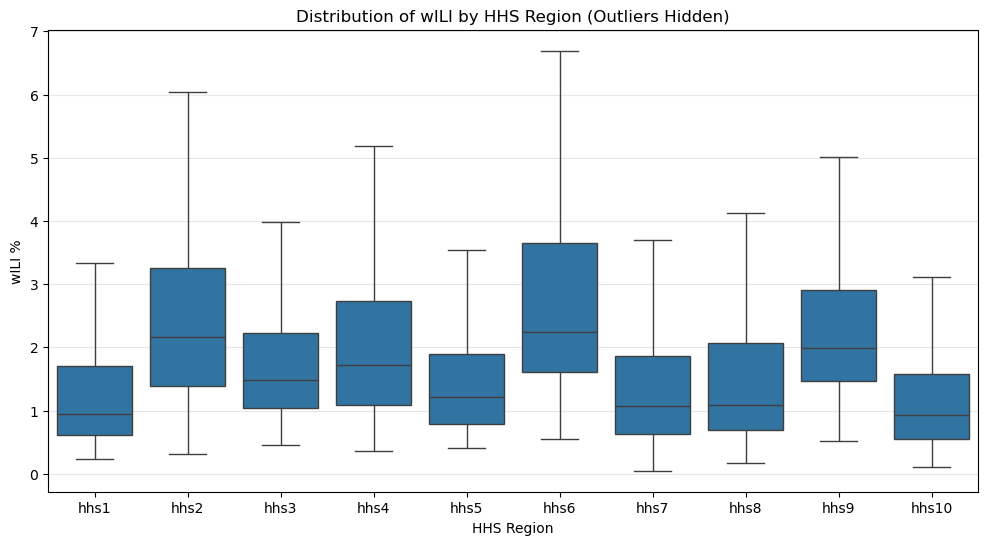

In [40]:
# Filter for just the HHS regions (hhs1 ... hhs10)
hhs_data = df[df['region'].str.startswith('hhs')].copy()

hhs_data['region_num'] = hhs_data['region'].str.extract('(\d+)').astype(int)
hhs_data = hhs_data.sort_values('region_num')

plt.figure(figsize=(12, 6))
sns.boxplot(data=hhs_data, x='region', y='wili', showfliers=False) # Hide extreme outliers for clarity
plt.title('Distribution of wILI by HHS Region (Outliers Hidden)')
plt.xlabel('HHS Region')
plt.ylabel('wILI %')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [49]:
df.head()
df.to_csv("influenza_data.csv")